In [2]:
import pvdeg.stressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Creating a Chamber Setpoint File

This set of functions is used to create pseudo-weather files that specify the environmental conditions in a chamber as opposed to outdoors. To start, a simplified set of environmental chamber setpoints must be created. Some example profiles that are commonly used in the PV industry or that come from standardized testing regimes are located in the folder, 'put in the folder name ' in the form of encoded *.csv files. 

The *.csv files are structed as...

If you combine sequences together, remember to remove the first line corresponding to the initial conditions.

Using preset sequences we could do the following. Or these could refer to variables in the pvdeg namespace.  
`sequence=['wet_hot', 'wet_hot', 'dry_hot', 'cold_superwet']`  

This would just be one loop but because of convienent python syntax we could do the following to repeat the sequence twice.  `sequence * 2`

In [4]:
points = pvdeg.chamber.setpoints_timeseries_from_csv(
    fp=r"./chamber-setpoints.csv",
    setpoint_names=["temperature", "relative_humidity"]
)

<Axes: title={'center': 'chamber setpoints'}>

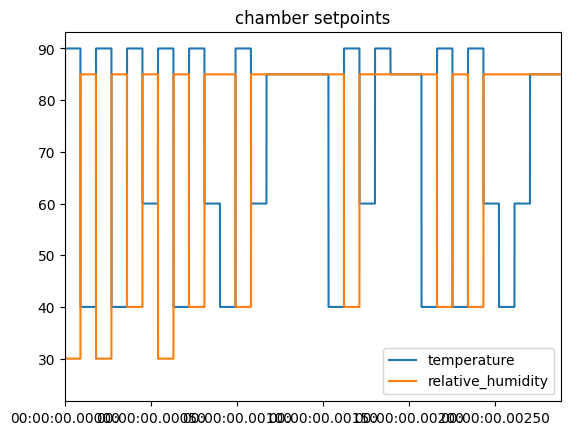

In [5]:
points.plot(title='chamber setpoints')

In [6]:
points

,temperature,relative_humidity
0 days 00:00:00,25.0,50.0
0 days 00:01:00,90.0,30.0
0 days 00:02:00,90.0,30.0
0 days 00:03:00,90.0,30.0
0 days 00:04:00,90.0,30.0
...,...,...
33 days 07:56:00,85.0,85.0
33 days 07:57:00,85.0,85.0
33 days 07:58:00,85.0,85.0
33 days 07:59:00,85.0,85.0


## Calculating Chamber Conditions

Use `chamber_properties` to calculate the conditions in the chamber at each timestep.

- tau_c : Chamber equilibraiton time [min]
- tau_s : Sample equilibration time [min]
- To_s :   Sample initial temperature [°C]
- Ea_ecap_s : Encapsulant activation energy for solubility [kJ/mol]
- So_encap_s : Encapsulant solubility prefactor [g/cm³]
- encap_num : Encapsulant reference number. This will pull data from the PVDeg library for the Arrhenius solubility and diffusivity calculations. In a conflict, this will override individual entries but does not include the thickness.
- bs_num : This will pull in values for permeability of the backsheet.

In [ ]:
props = pvdeg.stressor.chamber_properties(
    set_point_df=points, 
    tau=10, 
    chamber_irrad_0=0, 
    sample_temp_0=25,
    eva_solubility=0.17337995,
    solubility_prefactor=1.81390702,
    pet_permiability=0.553059381,
    pet_prefactor=674449898.1,
    thickness_eva=0.4572,
    thickness_pet=0.1016,
    )

In [ ]:
props

## checking things

Good
- water vapor $P$
- dew point
- set points
- sample temperature is functional and matches spreadsheet for test cases

Still questionable 
- backsheet_moisture	

In [ ]:
props['sample_temperature'].plot() # should have a max of 90
plt.axhline(props['sample_temperature'].max(), c='r', linestyle='-.' )
plt.axhline(y=90, c='black', linestyle=':')
plt.title('Sample Temperatures (WRONG), black line should be correct maximum')

### Changing Tau

$\tau$ characteristic thermal equilibration time. Because our timescale is relatively small

$\tau = RC$ where R is the thermal resistance from the object to the surroundings and C is the objects thermal capacitance. This gives us a general sense of the time scale


### Changing Tau Timescale (IS THIS VALID???)

Say we know  $\tau = 10$ at a timescale where eachstep represents a change of, $\Delta T = 58.3$ minutes. Isolating $\tau$ in the finite differenence temperature model used in the `pvdeg.temperature.chamber_sample_temperature` yields the following,  
$\tau = \frac{-\Delta t}{\ln{\frac{T_2 - T_0}{T_1 - T_0}}}$

This shows that $\tau$ has a linear relationship with $\Delta T$ so we can simply convert by dividing $\tau_{new} = \tau_{old} / \Delta t_{old} * \Delta t_{new}$



In [ ]:
props = pvdeg.stressor.chamber_properties(
    set_point_df=points, 
    tau=10 / 58.33471892 * 1, # new tau calculated using equation above
    chamber_irrad_0=0, 
    sample_temp_0=25,
    eva_solubility=0.17337995,
    solubility_prefactor=1.81390702,
    pet_permiability=0.553059381,
    pet_prefactor=674449898.1,
    thickness_eva=0.4572,
    thickness_pet=0.1016,
    )

### All Chamber Data

By concatenating the dataframes we can see all of the data in one place.

In [ ]:
comb = pd.concat([points, props], axis=1)
comb

### Front of Cell Water Concentration Profile

Using a numerical solution to the 2D diffusion equation we can determine the water concentration in the pannel at a given time. Each 2D matrix in the result represents nodes on the cell in 2d at a timestep in the input dataframe. We are using a right triangle that represents $1/8$ of the area of the module.

$C^{P+1}_{m,n} = \frac{D \Delta t}{(\Delta X)^2}(C^{P}_{m+1,n} + C^{P}_{m-1,n} + C^{P}_{m, n+1} + C^{P}_{m, n-1}) + [1 - 4 \frac{D \Delta t}{(\Delta X)^2}]C^{P}{m,n}$

In [ ]:
res = pvdeg.humidity.module_front(
    chamber_properties=comb
)

## Viewing Our Results

The cell below shows the end state of the water concentration in the front of the module. And the following cell renders an interactive animation showing concentrations in the cell at each timestep. note: the animation requires plotly, not included in pvdeg depedency list. install using `pip install plotly`.

In [ ]:
plt.matshow(res[-1], cmap='viridis')

In [ ]:
import plotly.subplots
import plotly.graph_objects as go

fig = plotly.subplots.make_subplots(rows=1,cols=1)
frame = go.Frame(data=go.Heatmap(z=res[0], colorscale='Viridis'))
frames = [go.Frame(data=go.Heatmap(z=res[i], colorscale='Viridis'), name=str(i)) for i in range(res.shape[0])]

fig.add_trace(go.Heatmap(z=res[0], colorscale='Viridis'))

fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 100, 'redraw': True}, 'fromcurrent': True}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate'}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Frame:',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': [
            {
                'args': [[str(k)], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate'}],
                'label': str(k),
                'method': 'animate'
            } for k in range(res.shape[0])
        ]
    }]
)

# Add the frames to the figure
fig.frames = frames

# Show the figure
fig.show()

### Optional: Save plot

Save the interactive plot to an HTML file which can be reopened and interacted with later.

In [ ]:
import plotly.io as pio
pio.write_html(fig, 'diffusion_plot.html', auto_open=True)